# Introduction
In this project we are tasked to improve the speed and accuracy of detecting and localizing brain tumors based on MRI scans.

* data Source: https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation


# Import libraries and datasets

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random

%matplotlib inline

In [ ]:
#Mount the drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Brain_MRI

/content/drive/MyDrive/Colab Notebooks/Brain_MRI


In [ ]:
# data containing path to Brain MRI and their corresponding mask
brain_df = pd.read_csv('data_mask.csv')
brain_df['image_path'] = brain_df['image_path'].apply(lambda x: x)  # No need to prepend 'Data/'
brain_df['mask_path'] = brain_df['mask_path'].apply(lambda x: x)  # No need to prepend 'Data/'

brain_df.head(10)


,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0
5,TCGA_CS_5395_19981004,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1.tif,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1_...,0
6,TCGA_CS_5395_19981004,TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1.tif,TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1_...,0
7,TCGA_CS_5395_19981004,TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_1.tif,TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_1_...,0
8,TCGA_CS_5395_19981004,TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_1.tif,TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_1_...,0
9,TCGA_CS_5395_19981004,TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_1.tif,TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_1_...,0


In [ ]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [ ]:
brain_df.mask_path[1] # Ruta de la imagen de la MRI

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif'

In [ ]:
brain_df.image_path[1] # Ruta de la imagen de segmentacion

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif'

In [ ]:
brain_df['mask'].value_counts()

,count
mask,
0,2556
1,1373


# Perform Simple Data Visualization

### 1. Visualize value counts of the masks

In [ ]:
brain_df['mask'].value_counts().index

Index([0, 1], dtype='int64', name='mask')

In [ ]:
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color = 'rgb(0,200,0)', marker_line_color = 'rgb(0,255,0)',
                  marker_line_width = 7, opacity = 0.6)
fig.show()

### 2. Plot 12 randomly selected (1) MRI scan images from only sick patients followed by corresponding mask.

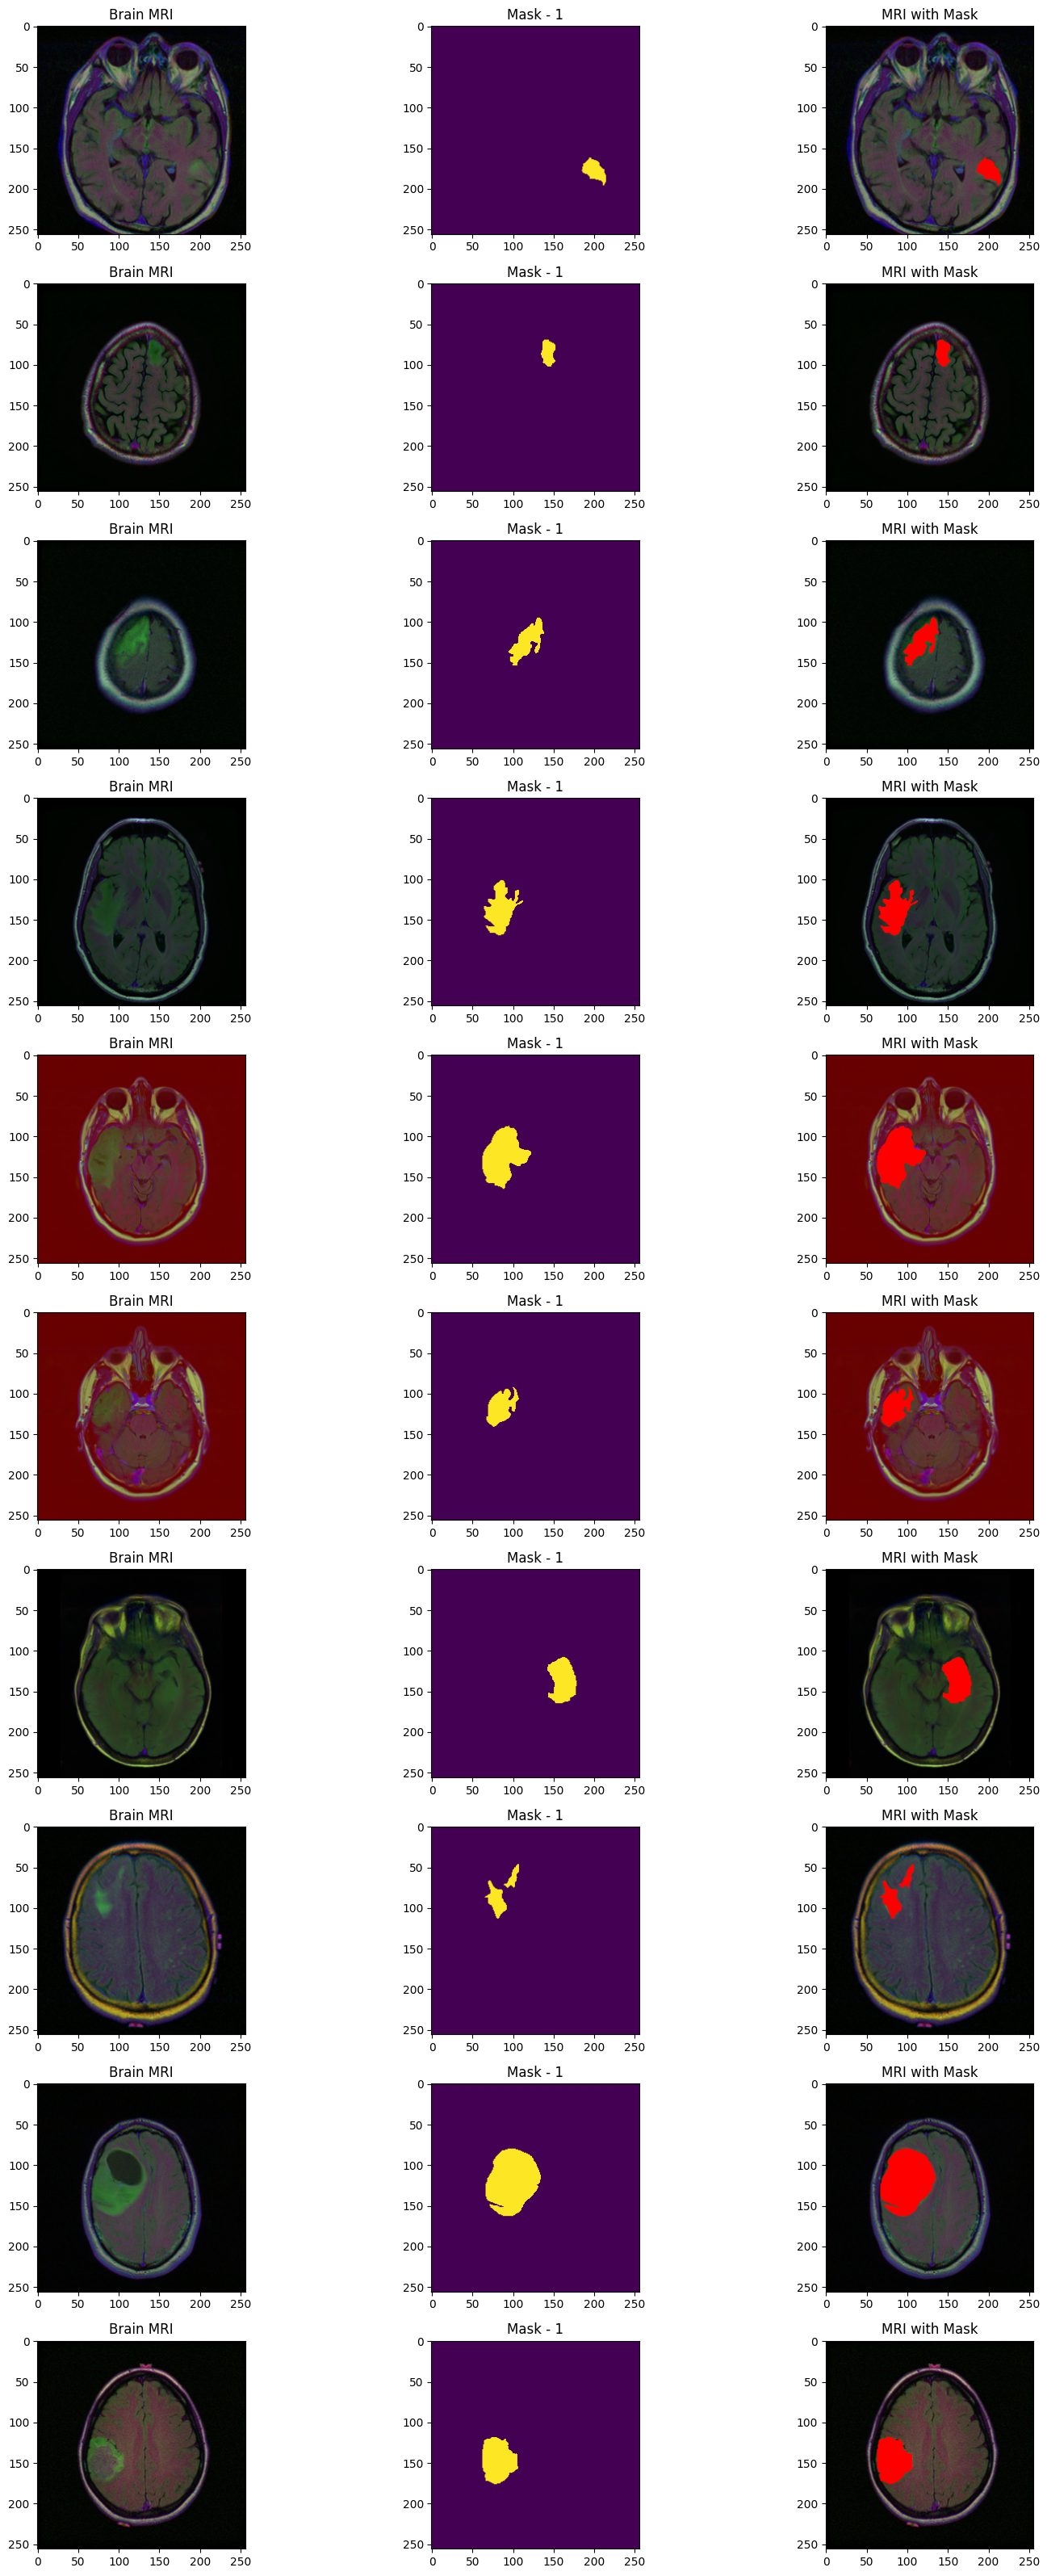

In [ ]:
"""
Plot 12 randomly selected (1) MRI scan images from only sick patients followed by corresponding mask,
both MRI image and the corresponding mask (in red color) on top of each other
"""
import random
fig, axs = plt.subplots(10,3, figsize=(16,32))
count = 0
h_indexes = brain_df['mask'][brain_df['mask']==1].index.tolist()
for x in range(10):
    i = random.choice(h_indexes) # select a random index
    mri_img=io.imread(brain_df.image_path[i])

    axs[count][0].title.set_text("Brain MRI") # set title
    axs[count][0].imshow(mri_img) # show MRI

    msk_img=io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
    axs[count][1].imshow(msk_img) # Show corresponding mask

    mri_img[msk_img==255] = (255,0,0)
    axs[count][2].title.set_text("MRI with Mask")
    axs[count][2].imshow(mri_img)
    count += 1

fig.tight_layout()

# Train A Classifier Model To Detect If Tumor Exists Or Not

In [ ]:
# Drop the patient id column
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [ ]:
#convert mask from int to strings
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [ ]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [ ]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size = 0.15)

In [ ]:
# Necesario en las nuevas versiones de python en colab
!pip install Keras-preprocessing
# create a image generator
from keras_preprocessing.image import ImageDataGenerator

# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.6 MB/s eta 0:00:00


In [ ]:
# creating train validation and test data generators
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


## Understanding Intuition behind Resnets

* As CNNs grow deeper, vanishing gradient tend to occur which negatively impact network performance.
* Vanishing gradient problem occurs when the gradient is back-propagated to earlier layers which results in a very small gradient.
* Residual Neural Network includes “skip connection” feature which enables training of 152 layers without vanishing gradient issues.
* Resnet works by adding “identity mappings” on top of the CNN.
* ImageNet contains 11 million images and 11,000 categories.

### Get the ResNet50 model (Pretrained on imagenet data)

* Transfer learning is a machine learning technique in which a network that has been trained to perform a specific task is being reused (repurposed) as a starting point for another similar task.

* We'll freeze the trained CNN network weights from the first layersand only train the newly added dense layers (with randomly initialized weights).

In [ ]:
# Get the ResNet50 base model
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
basemodel.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# freeze the model weights

for layer in basemodel.layers:
    layers.trainable = False

### Add classification head to the base model

In [ ]:
#
#experiment with different designs.

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)

headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,751,426 (98.23 MB)

 Trainable params: 25,698,306 (98.03 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# compile the model

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

# Assess Trained Model Performance

In [ ]:
# Load pretrained model (instead of training the model for 1+ hours)
with open('resnet-50-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model, providing the 'Model' class as a custom object
model = tf.keras.models.model_from_json(json_savedModel, custom_objects={'Model': tf.keras.models.Model}) # Providing 'Model' class as a custom object
model.load_weights('weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
# make prediction

test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



36/36 ━━━━━━━━━━━━━━━━━━━━ 329s 9s/step


In [ ]:
test_predict

array([[1.6110087e-05, 9.9998385e-01],
       [9.9538386e-01, 4.6161008e-03],
       [9.9991554e-01, 8.4414547e-05],
       ...,
       [9.9999982e-01, 1.1123829e-07],
       [9.5081687e-06, 9.9999040e-01],
       [9.9999994e-01, 7.8200733e-15]], dtype=float32)

In [ ]:
# Obtain the predicted class from the model prediction
predict = []

for i in test_predict:
    predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [ ]:
predict[:50]

array(['1', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0',
       '0', '0', '0', '1', '1', '1', '1', '1', '0', '0', '0', '0', '0',
       '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '1', '0', '1', '1', '1', '0', '0', '1', '0', '0', '0'], dtype='<U1')

In [ ]:
# since we have used test generator, it limited the images to len(predict), due to batch size
original = np.asarray(test['mask'])[:len(predict)]
len(original)

576

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(predict,original)
accuracy

0.9826388888888888

<Axes: >

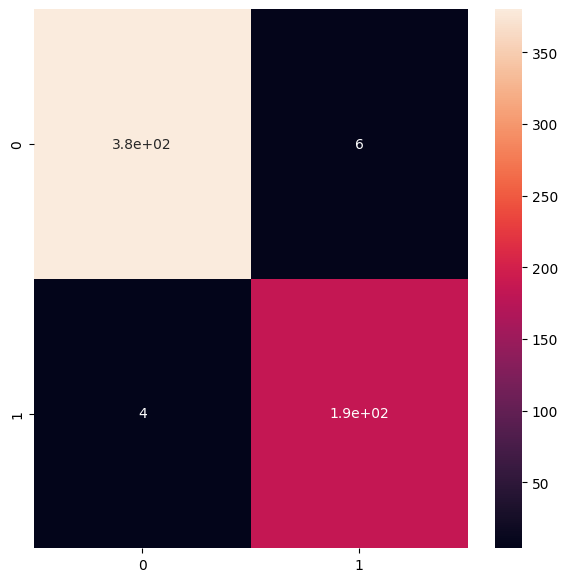

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(predict,original)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [ ]:
#Print out the classification report. ie the precision, recall and F1-score results
from sklearn.metrics import classification_report
report = classification_report(predict,original)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       386
           1       0.97      0.98      0.97       190

    accuracy                           0.98       576
   macro avg       0.98      0.98      0.98       576
weighted avg       0.98      0.98      0.98       576



* The model performs really well

# Understand The Intuition Behind Resunet Models
- ResUNet architecture combines UNet backbone architecture with residual blocks to overcome the vanishing gradients problems present in deep architectures.
- Unet architecture is based on Fully Convolutional Networks and modified in a way that it performs well on segmentation tasks.

Resunet consists of three parts:
1. Encoder or contracting path.
    - First block consists of 3x3 convolution layer + Relu + Batch-Normalization
    - Remaining three blocks consist of Res-blocks followed by Max-pooling 2x2.
2. Bottleneck.
    - It is in- in-between the contracting and expanding path.
    - It consist of Res-block followed by up sampling conv layer 2x2.
3. Decoder or expansive path.
    - 3 blocks following bottleneck consist of Res-blocks followed by up-sampling conv layer 2 x 2
    - Final block consist of Res- Res-block followed by 1x1 conv layer.

# Build A Segmentation Model To Localize Tumor

In [ ]:
# Get the dataframe containing MRIs which have masks associated with them.
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [ ]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

In [ ]:
# create separate list for imageId, classId to pass into the generator

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [ ]:
# Utilities file contains the code for custom loss function and custom data generator
from utilities import DataGenerator

# create image generators

training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [ ]:
#Function to representt the resblock in the resunet model
def resblock(X, f):
    # make a copy of input
    X_copy = X

    # main path
    # Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

    X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
    X = BatchNormalization()(X)

    # Short path
    # Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

    X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)

    # Adding the output from main path and short path together

    X = Add()([X,X_copy])
    X = Activation('relu')(X)

    return X

In [ ]:
# function to upscale and concatenate the values passed
def upsample_concat(x, skip):
    x = UpSampling2D((2,2))(x)
    merge = Concatenate()([x, skip])

    return merge

In [ ]:
"""
ResUnet Localization Model
"""
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output, name='ResUnet')


In [ ]:
model_seg.summary()

Model: "ResUnet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            448 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 16)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 16)   │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │            544 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 32)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 32)   │            544 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 32)   │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 128, 128, 32)   │            128 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 128, 128, 32)   │              0 │ batch_normalization_3… │
│                           │                        │                │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 32)   │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1      

 Total params: 1,210,513 (4.62 MB)

 Trainable params: 1,206,129 (4.60 MB)

 Non-trainable params: 4,384 (17.12 KB)

# Train A Segmentation Resunet Model To Localize Tumor

In [ ]:
# Utilities file contains the code for custom loss function and custom data generator

from utilities import focal_tversky, tversky_loss, tversky

In [ ]:
# Compile the model
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

I've used the tversky loss function. Its implemented from this <a href ="https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py">repository</a>:

Check this article to find out more about the tversky loss function: @article{focal-unet, title={A novel Focal Tversky loss function with improved Attention U-Net for lesion segmentation}, author={Abraham, Nabila and Khan, Naimul Mefraz}, journal={arXiv preprint arXiv:1810.07842}, year={2018} }

In [ ]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-weights.keras", verbose=1, save_best_only=True)

# Assess Trained Segmentation Resunet Model Performance

In [ ]:
from utilities import focal_tversky, tversky_loss, tversky
import tensorflow as tf

with open('ResUNet-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model architecture, providing the 'Model' class as a custom object
model_seg = tf.keras.models.model_from_json(json_savedModel, custom_objects={'Model': tf.keras.models.Model}) # Providing 'Model' class as a custom object
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [ ]:
# Utilities file contains the code for custom loss function and custom data generator
from utilities import prediction

# making prediction
image_id, mask, has_mask = prediction(test, model, model_seg)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160

In [ ]:
# creating a dataframe for the result
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

,image_path,predicted_mask,has_mask
0,TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_12...,"[[[[7.591379e-07], [3.0622198e-06], [7.0080423...",1
1,TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_57...,No mask,0
2,TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_30...,No mask,0
3,TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_36...,"[[[[7.816445e-07], [2.816899e-06], [5.846611e-...",1
4,TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_11...,No mask,0
...,...,...,...
585,TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_50...,No mask,0
586,TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_20...,"[[[[8.9121335e-07], [4.457088e-06], [1.1528704...",1
587,TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_24...,"[[[[7.697377e-07], [2.6042026e-06], [4.682797e...",1
588,TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_2.tif,No mask,0


In [ ]:
# Merge the dataframe containing predicted results with the original test data.
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

,image_path,mask_path,mask,predicted_mask,has_mask
0,TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_12...,TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_12...,1,"[[[[7.591379e-07], [3.0622198e-06], [7.0080423...",1
1,TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_57...,TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_57...,0,No mask,0
2,TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_30...,TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_30...,0,No mask,0
3,TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_36...,TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_36...,1,"[[[[7.816445e-07], [2.816899e-06], [5.846611e-...",1
4,TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_11...,TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_11...,0,No mask,0


In [ ]:
#Visually verify that model predictions make sense
pos_indexes = df_pred[df_pred['has_mask']==1].index.tolist()
fig, ax = plt.subplots(10, 5, figsize=(50,150))

for i in range(10):
    idx = random.choice(pos_indexes)
    mri_img = io.imread(df_pred['image_path'][idx])
    ax[i][0].title.set_text('MRI')
    ax[i][0].imshow(mri_img)

    mask_img = io.imread(df_pred['mask_path'][idx])
    ax[i][1].title.set_text('Mask')
    ax[i][1].imshow(mask_img)

    mri_img[mask_img==255] = (255,0,0)
    ax[i][2].title.set_text('MRI + Mask')
    ax[i][2].imshow(mri_img)

    predicted_mask = np.asarray(df_pred.predicted_mask[idx])[0].squeeze().round()
    ax[i][3].title.set_text('Predicted Mask')
    ax[i][3].imshow(predicted_mask)

    mri_img = io.imread(df_pred['image_path'][idx])
    mri_img[predicted_mask==1] = (0,255,0)
    ax[i][4].title.set_text('MRI + Predicted Mask')
    ax[i][4].imshow(mri_img)

fig.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

* The results are pretty good.
* Definitely production grade.

## Thank you!! for taking time to go through this notebook.